In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from pgmpy.inference import VariableElimination
import warnings
import json
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
warnings.filterwarnings("ignore")

# BayesianPokemon
This Project aim to test the capacities of the Bayesian Networks in predict the right move during a Pokèmon Battle

Pokèmon is turn-based role playing game, where two player fight with a team of 6 pokèmon. Every battle is divided in turn and during each one them a player can choose between various option, for this option I used the tournament rules, so the only possible action are the 4 moves of the pokèmon, or switch with another Pokèmon of the team.


The Project is the divided in various part, but before all the project, I needed to create a Dataset, because there wasn't any that could be used. To do this I used a website, called [PokemonShowdown](https://play.pokemonshowdown.com), this website emulate the game engine of the Pokèmon game and let you play battle against people online. What I used was the possibility to download the log of the battle done by other people on the platform <https://replay.pokemonshowdown.com/>.

The log looked like this:

" |t:|1708228838 

|move|p1a: Lilligant|Petal Dance|p2a: Magcargo

|-crit|p2a: Magcargo

|-damage|p2a: Magcargo|0 fnt

|faint|p2a: Magcargo

|-damage|p1a: Lilligant|25\/249 tox|[from] item: Life Orb

|-damage|p1a: Lilligant|0 fnt|[from] psn

|faint|p1a: Lilligant

|upkeep "

so I needed to create a Parser to extrapolate the usefull information and then create the Dataset to use for the Bayesiab Network.

## PreProcesing

The first part of the project consist in the PreProcessing of the Dataset. I had to operate various transformation on the value in the Dataset, the most important being the discretization on some of the column to reduce the dimension of the Network. Some column were already discrete, but had too much value, which weighted the Network a lot.

Other than that I have done some general operation of Preprocessing on the Dataset, mostly for clarity of the Dataset.



## Weakness file
I load the Weakness file needed to calculate the multiplicator of damage

In [3]:

with open("../../../../data/Weakness.json", 'r+') as weakfile:
    weak = json.load(weakfile)
    weakfile.close()
    

# Utility function
This 3 function are needed for the preprocessing and to reduce the number of value.
## Generate_Multiplicator
This function generate a multiplicator based on the enemy type and on the type of the enemy, the relation between those two is expressed in the weakness file loaded before.
The weakness file is a dictionary that contain the information on this image.

<img alt="Image of weakness" src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/97/Pokemon_Type_Chart.svg/480px-Pokemon_Type_Chart.svg.png"/>

## percentage_Transform
This function transform the absolute value of the HP of a pokemon in the percentage value.

## check_stab
This function check if the type of the Pokemon is the same of the move in analysis

In [4]:
def Generate_Multiplicator(x):
    EnemyType = x["Enemy Type"]
    MoveType = x["Type Move"]
    weakness = 1
    EnemyType = EnemyType.split(",")
    for i in range(len(EnemyType)):
        if i == 0:
            EnemyType[i] = EnemyType[i][2:-1]
        elif i == 1:
            EnemyType[1] = EnemyType[1][2:-2]
    for Type in EnemyType:
        if not Type.isalnum():
            continue
        weakness = weakness * weak[MoveType][Type] 
    return weakness

def percentage_Transform(s):
    
    l = s.split("\/")
    l = list(map(lambda n: int(n),l))
    p = (l[0]/l[1] * 100)
    
    return p

def check_stab(DF):
    new_col = []
    for i in range(len(DF)):
        if DF['Pokemon Type'][i].split('\'')[1] == DF['Type Move'][i] or (len(DF['Pokemon Type'][i].split('\'')) > 3 and DF['Pokemon Type'][i].split('\'')[3] == DF['Type Move'][i]):
            new_col.append(True)
        else:
            new_col.append(False)
    DF = DF.assign(stab=new_col)
    DF = DF.drop(['Pokemon Type', 'Type Move'], axis= 1)
    return DF

In this cell we applied the previous function on the Dataset and aggregate all the various boost column in to a single one.

In [5]:
#load the dataset
df = pd.read_csv("../parsing Dataset/log/Dataset.csv") 

#transform the life of the Pokèmon from absolute value to percentage
df["UserHP"] = df["UserHP"].map(percentage_Transform)
df["SuffererHP"] = df["SuffererHP"].map(percentage_Transform)

#rename of the column to match the node of the network
df.rename({"UserHP": "Pokemon HP","SuffererHP": "Enemy HP","TypeM": "Type Move",
           "categoryMove": "Category","TypesS" : "Enemy Type","TypesU":"Pokemon Type",
           "power":"Power"}, axis=1, inplace=True)

#to reduce the number of node and value, we decide to calculate the multipicator (the "power") of the move with respect to the type of the enemy
df["Multiplicator"] = df[["Enemy Type","Type Move"]].apply(Generate_Multiplicator, axis=1)
#for every move we check if it has the same type of the Pokèmon that use it
df = check_stab(df)

#we adjust some text in the dataset
df["Weather"] = df["Weather"].str.rstrip().str.lower()
df["Status enemy"] = df["Status enemy"].str.rstrip().str.lower()
df["Sufferer"] = df["Sufferer"].str.rstrip().str.lower()
df["User"] = df["User"].str.rstrip().str.lower()

#a Pokèmon can have up to 7 different boost, each with 5 different value, this would cause a massive increase of the complexity, to avoid this, we summed all the bost in a single one
df["Boost"] = df["attack_boost"] + df["defense_boost"] + df["special_attack_boost"] + df["special_defense_boost"] + df["speed_boost"] + df["evasion_boost"] + df["accuracy_boost"]


#we remove the useless column
df = df.drop(["accuracy_boost","speed_boost","evasion_boost",
              "attack_boost","defense_boost","special_attack_boost","special_defense_boost","Enemy Type"],axis=1)

df



,User,Sufferer,name move,Power,Pokemon HP,Enemy HP,Weather,Category,Status enemy,Choose,Multiplicator,stab,Boost
0,klinklang,klinklang,Substitute,0,100.000000,100.000000,none,status,normal,1.0,1.0,False,0.0
1,hydreigon,klinklang,U-turn,70,100.000000,100.000000,none,physical,normal,1.0,1.0,False,0.0
2,klinklang,emboar,Return,102,100.000000,100.000000,none,physical,normal,1.0,1.0,False,0.0
3,klinklang,emboar,Substitute,0,100.000000,100.000000,none,status,normal,0.0,1.0,False,0.0
4,emboar,klinklang,Fire Blast,110,100.000000,100.000000,none,special,normal,1.0,1.0,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8468,persian,persian,Nasty Plot,0,100.000000,100.000000,none,status,par,1.0,1.0,False,0.0
8469,entei,persian,Sacred Fire,100,72.638436,100.000000,none,physical,par,1.0,1.0,True,-2.0
8470,persian,entei,Dark Pulse,80,100.000000,72.638436,none,special,psn,1.0,1.0,False,2.0
8471,persian,entei,Nasty Plot,0,100.000000,100.000000,none,status,psn,0.0,1.0,False,2.0


Here by using the sklearn function we Discretize four column: HP of the Pokèmon, HP of the enemy, the Power of the move and the Boost attribute. For all of them it has been used the kmeans strategy so that the final value would not accumulate too much on the end of range.  

In [6]:
from sklearn.preprocessing import KBinsDiscretizer

#we reduce the number of differente value for some numeric variable to reduce the complexity of the network
enc = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
enc.fit(df[["Pokemon HP"]])
df["Pokemon HP"] = enc.transform(df[["Pokemon HP"]]).astype(int)

enc = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
enc.fit(df[["Enemy HP"]])
df["Enemy HP"] = enc.transform(df[["Enemy HP"]]).astype(int)

enc = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
enc.fit(df[["Power"]])
df["Power"] = enc.transform(df[["Power"]]).astype(int)

enc = KBinsDiscretizer(n_bins=3, encode='ordinal',strategy='kmeans')
enc.fit(df[["Boost"]])
df["Boost"] = enc.transform(df[["Boost"]]).astype(int)

df

,User,Sufferer,name move,Power,Pokemon HP,Enemy HP,Weather,Category,Status enemy,Choose,Multiplicator,stab,Boost
0,klinklang,klinklang,Substitute,0,4,4,none,status,normal,1.0,1.0,False,1
1,hydreigon,klinklang,U-turn,1,4,4,none,physical,normal,1.0,1.0,False,1
2,klinklang,emboar,Return,2,4,4,none,physical,normal,1.0,1.0,False,1
3,klinklang,emboar,Substitute,0,4,4,none,status,normal,0.0,1.0,False,1
4,emboar,klinklang,Fire Blast,2,4,4,none,special,normal,1.0,1.0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8468,persian,persian,Nasty Plot,0,4,4,none,status,par,1.0,1.0,False,1
8469,entei,persian,Sacred Fire,2,2,4,none,physical,par,1.0,1.0,True,1
8470,persian,entei,Dark Pulse,1,4,3,none,special,psn,1.0,1.0,False,1
8471,persian,entei,Nasty Plot,0,4,4,none,status,psn,0.0,1.0,False,1


## Creation of the Network for the Move
Here start the second part of the Project.
In this cell we create the Bayesian Newtork using the pgmpy library, we do this by specifing the relation between each Variable.
Then we create an image of the Network for explanation "pourpouse(non ricordo come si scrive)".

The idea for this network was to consider it for every possible action of the Pokemon, which are the four Move that the Pokèmon can use.

All the node, with exception for the Choose one, rappresent some information on the current state of the battle:
   1. Pokèmon HP : it rapresent the remaining health of the player's Pokèmon
   2. Enemy HP : it rapresent the remaining health of the enemy's Pokèmon
   3. Status enemy : it rapresent the status condition that affects the enemy's Pokèmon
   4. stab : it rapresent if the current move has the same type of the Pokèmon
   5. Multiplicator : it rapresent the multiplicator facto that the move would receive against the enemy's Pokèmon
   6. Power : it rappresent the amount of base damage that the move inflict
   7. Weather : it rapresent the weather condition present on the battlefield
   8. Category : it rapresent the category of the move
   9. Boost : it rapresent the total boost that player's Pokèmon currently have
    
All of this variable directly influence the Choose variable, which indicates if the move, in the previous condition, should be choosen.
    

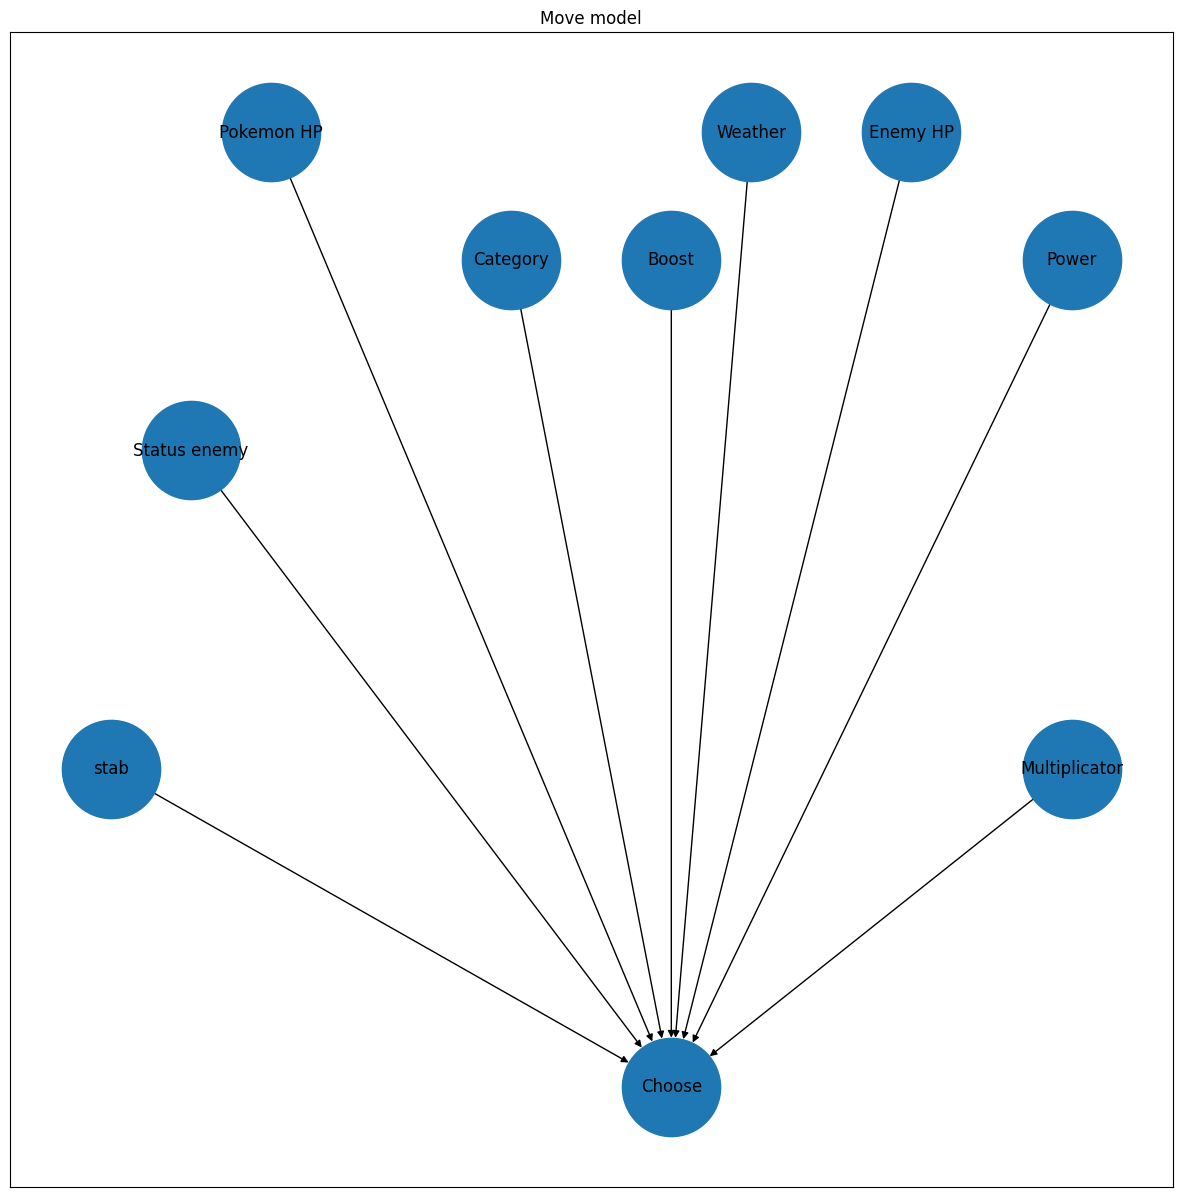

In [7]:
#we create the bayesian network
Move_model = BayesianNetwork([('Pokemon HP', 'Choose'), ('Enemy HP', 'Choose'), ('Status enemy', 'Choose'),
                              ('stab', 'Choose'), ('Multiplicator', 'Choose'), ('Power', 'Choose'),
                               ("Weather","Choose"), ("Category","Choose"), ("Boost","Choose"),
                                    ])
#we give to every node a position
position = {'Pokemon HP': [0.5, 0], 'Enemy HP': [1.3, 0],
       "stab": [0.3, -1.], 'Multiplicator': [1.5, -1],
       'Power': [1.5, -0.2], "Weather" : [1.1, 0],
       'Choose': [1, -1.5],"Category" : [0.8, -0.2], "Boost": [1,-0.2],"Status enemy" : [0.4, -0.5],
       }

#and we plot the network
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
nx.draw_networkx(Move_model, pos=position, ax=ax, node_size=5000)
ax.set_title('Move model')
fig.savefig('Move_bn')

## CPD Estimation
In this cell we use the Bayesian Estimator to calculate the parameter for every node in the Bayesian Network.

The Bayesian Estimator was choosen because of the simplicity of the network and the fact that there are no latent variable

In [8]:

#we use the Bayesian Estimator to calculate the parameter of the bayesian Network
estimator = BayesianEstimator(model=Move_model, data=df)

CPDs = []
#for every node we estimate the parameter and add them to the list
for node in Move_model.nodes():
    CPDs.append(estimator.estimate_cpd(node=node, 
                                        prior_type="BDeu", 
                                        equivalent_sample_size=3500))
    
#then we add the CPDs to the model
Move_model.add_cpds(*CPDs)

#we check the model
print('Checking the model...')
print(f'The model is {Move_model.check_model()}\n\n')

#and we see the parameter for every node
for cpd in [cpd for cpd in Move_model.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd)

Checking the model...
The model is True


CPD for Pokemon HP:
+---------------+-----------+
| Pokemon HP(0) | 0.0743339 |
+---------------+-----------+
| Pokemon HP(1) | 0.0918734 |
+---------------+-----------+
| Pokemon HP(2) | 0.101979  |
+---------------+-----------+
| Pokemon HP(3) | 0.138478  |
+---------------+-----------+
| Pokemon HP(4) | 0.593335  |
+---------------+-----------+
CPD for Choose:
+---------------+-----+--------------------+
| Boost         | ... | Boost(2)           |
+---------------+-----+--------------------+
| Category      | ... | Category(status)   |
+---------------+-----+--------------------+
| Enemy HP      | ... | Enemy HP(4)        |
+---------------+-----+--------------------+
| Multiplicator | ... | Multiplicator(4.0) |
+---------------+-----+--------------------+
| Pokemon HP    | ... | Pokemon HP(4)      |
+---------------+-----+--------------------+
| Power         | ... | Power(4)           |
+---------------+-----+--------------------+
| Statu

## Inference
After the estimation of the Parameter the Network is ready to be used.
Given some evidence, which are the ipothetical condition during a battle, we predict the Probability of choosing the current move in examination. As algorithm I used the VariableElimination because even if it is exponential, it behave well on Network which a similar to a Tree, like the one I use

In [9]:
#we do a little test of the network, with an example of a situation in a battle

#this evidence is of a single move during a turn of a battle

EVIDENCE = {'Power': 2, #this means that is a move of medium power 
            'Multiplicator': 1, #the move has no advantage nor disadvantage against the enemy
            'stab': True, #the move has the same type of the Pokèmon so the damage is double
            'Enemy HP': 1, #the enemy has low life
            "Pokemon HP": 4, #the Pokèmon has full life
            "Category": "physical", #the move does damage
            "Weather": "none", #there is no weather condition
            "Status enemy": "normal", #The enemy has no alteration of his status
            "Boost":1 #the Pokèmon has a some boost to its statistics
            }

#We choose as inference model the VariableElimination one
inference = VariableElimination(Move_model)

prob = inference.query(["Choose"],EVIDENCE,
                          show_progress=True)
print(prob)

+-------------+---------------+
| Choose      |   phi(Choose) |
+=============+===============+
| Choose(0.0) |        0.0026 |
+-------------+---------------+
| Choose(1.0) |        0.9974 |
+-------------+---------------+


## Switch Bayesian Network
In the next Part we construct a Bayesian Network for the switch action: this is the possibility to change the current Pokèmon with another one in team.
As we did for the move, the network si for a single switch and will be used for every possible Pokèmon in the team.
Most of the following is the same as the one for the move, but with some differences. 

In [10]:
#we load the dataset for the switch 
df_switch = pd.read_csv("../parsing Dataset/log/Dataset-Switch.csv")

def Generate_Multiplicator_In_switch(x):
    EnemyType = x["Enemy Type"]
    InType = x["Pokemon In Type"]
    weakness = 1
    EnemyType = EnemyType.split(",")
    InType = InType.split(",")

    for i in range(max(len(EnemyType), len(InType))):
        if i == 0:
            EnemyType[i] = EnemyType[i][2:-1]
            InType[i] = InType[i][2:-1]
        elif i == 1:
            if len(EnemyType) > 1:
                EnemyType[1] = EnemyType[1][2:-2]
            if len(InType) > 1:
                InType[1] = InType[1][2:-2]
    for En_Type in EnemyType:
        if not En_Type.isalnum():
            continue
        for In_Type in InType:
            if not In_Type.isalnum():
                continue
            weakness = weakness * weak[In_Type][En_Type] 
    return weakness

def Generate_Multiplicator_Out_switch(x):
    EnemyType = x["Enemy Type"]
    OutType = x["Pokemon Out Type"]
    weakness = 1
    EnemyType = EnemyType.split(",")
    OutType = OutType.split(",")

    for i in range(max(len(EnemyType), len(OutType))):
        if i == 0:
            EnemyType[i] = EnemyType[i][2:-1]
            OutType[i] = OutType[i][2:-1]
        elif i == 1:
            if len(EnemyType) > 1:
                EnemyType[1] = EnemyType[1][2:-2]
            if len(OutType) > 1:
                OutType[1] = OutType[1][2:-2]
    for En_Type in EnemyType:
        if not En_Type.isalnum():
            continue
        for Out_Type in OutType:
            if not Out_Type.isalnum():
                continue
            weakness = weakness * weak[Out_Type][En_Type] 
    return weakness


## Switch Dataset
For this Network another Dataset is used, which differ from the one used for the move for this:
1. all the column regarding the move are eliminated, for obvious reason.
2. Multiplicator is divided in 2 column : Multiplicator in adn Multiplicator out which are, respectively the multiplicator between the types of the entering and the enemy, and the multiplicator between the exiting Pokemon and the enemy.

In [11]:
#we do the same preProcessing of the first dataset
df_switch["HPout"] = df_switch["HPout"].map(percentage_Transform)
df_switch["HPEnemy"] = df_switch["HPEnemy"].map(percentage_Transform)
df_switch["Weather"] = df_switch["Weather"].str.rstrip().str.lower()
df_switch["StatusP"] = df_switch["StatusP"].str.rstrip().str.lower()

df_switch.rename({"HPout": "Pokemon HP","HPEnemy": "Enemy HP","TypeEnemy" : "Enemy Type","TypeIN":"Pokemon In Type", "TypeOUT":"Pokemon Out Type", "StatusP":"Status Pokemon"}, axis=1, inplace=True)

#In this dataset we have the Multiplicator of the entering Pokèmon and of the outgoing one
df_switch["Multiplicator In"] = df_switch[["Enemy Type", "Pokemon In Type"]].apply(Generate_Multiplicator_In_switch, axis=1)
df_switch["Multiplicator Out"] = df_switch[["Enemy Type", "Pokemon Out Type"]].apply(Generate_Multiplicator_Out_switch, axis=1)

#then we drop the useless columns
df_switch = df_switch.drop(["Enemy Type", "Pokemon In Type", "Pokemon Out Type"], axis= 1)

df_switch

,Switch In,Switch out,enemy,Pokemon HP,Enemy HP,Status Pokemon,Weather,Switch,Multiplicator In,Multiplicator Out
0,Emboar,Hydreigon,Klinklang,100.000000,100.000000,normal,none,1.0,1.00,1.00
1,Lugia,Klinklang,Emboar,100.000000,100.000000,normal,none,1.0,4.00,1.00
2,Hydreigon,Emboar,Lugia,100.000000,100.000000,normal,none,1.0,2.00,0.25
3,Emboar,Hydreigon,Lugia,100.000000,100.000000,normal,none,1.0,0.25,2.00
4,Hydreigon,Emboar,Lugia,61.963190,100.000000,normal,none,1.0,2.00,0.25
...,...,...,...,...,...,...,...,...,...,...
5809,Fezandipiti,Gyarados,Chansey,100.000000,100.000000,normal,none,1.0,1.00,1.00
5810,Entei,Chansey,Fezandipiti,100.000000,38.545455,psn,none,1.0,1.00,1.00
5811,Rotom,Chansey,Fezandipiti,100.000000,38.545455,psn,none,0.0,1.00,1.00
5812,Persian,Fezandipiti,Entei,38.545455,72.638436,par,none,1.0,1.00,1.00


In [12]:

#we reduce the number of value for the HP
enc = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='uniform')
enc.fit(df_switch[["Pokemon HP"]])
df_switch["Pokemon HP"] = enc.transform(df_switch[["Pokemon HP"]]).astype(int)

enc = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='uniform')
enc.fit(df_switch[["Enemy HP"]])
df_switch["Enemy HP"] = enc.transform(df_switch[["Enemy HP"]]).astype(int)

df_switch

,Switch In,Switch out,enemy,Pokemon HP,Enemy HP,Status Pokemon,Weather,Switch,Multiplicator In,Multiplicator Out
0,Emboar,Hydreigon,Klinklang,4,4,normal,none,1.0,1.00,1.00
1,Lugia,Klinklang,Emboar,4,4,normal,none,1.0,4.00,1.00
2,Hydreigon,Emboar,Lugia,4,4,normal,none,1.0,2.00,0.25
3,Emboar,Hydreigon,Lugia,4,4,normal,none,1.0,0.25,2.00
4,Hydreigon,Emboar,Lugia,3,4,normal,none,1.0,2.00,0.25
...,...,...,...,...,...,...,...,...,...,...
5809,Fezandipiti,Gyarados,Chansey,4,4,normal,none,1.0,1.00,1.00
5810,Entei,Chansey,Fezandipiti,4,1,psn,none,1.0,1.00,1.00
5811,Rotom,Chansey,Fezandipiti,4,1,psn,none,0.0,1.00,1.00
5812,Persian,Fezandipiti,Entei,1,3,par,none,1.0,1.00,1.00


## Creating Network
Here we create the Network as we did for the Move. The procedure is the same as before even for the estimation and the inference

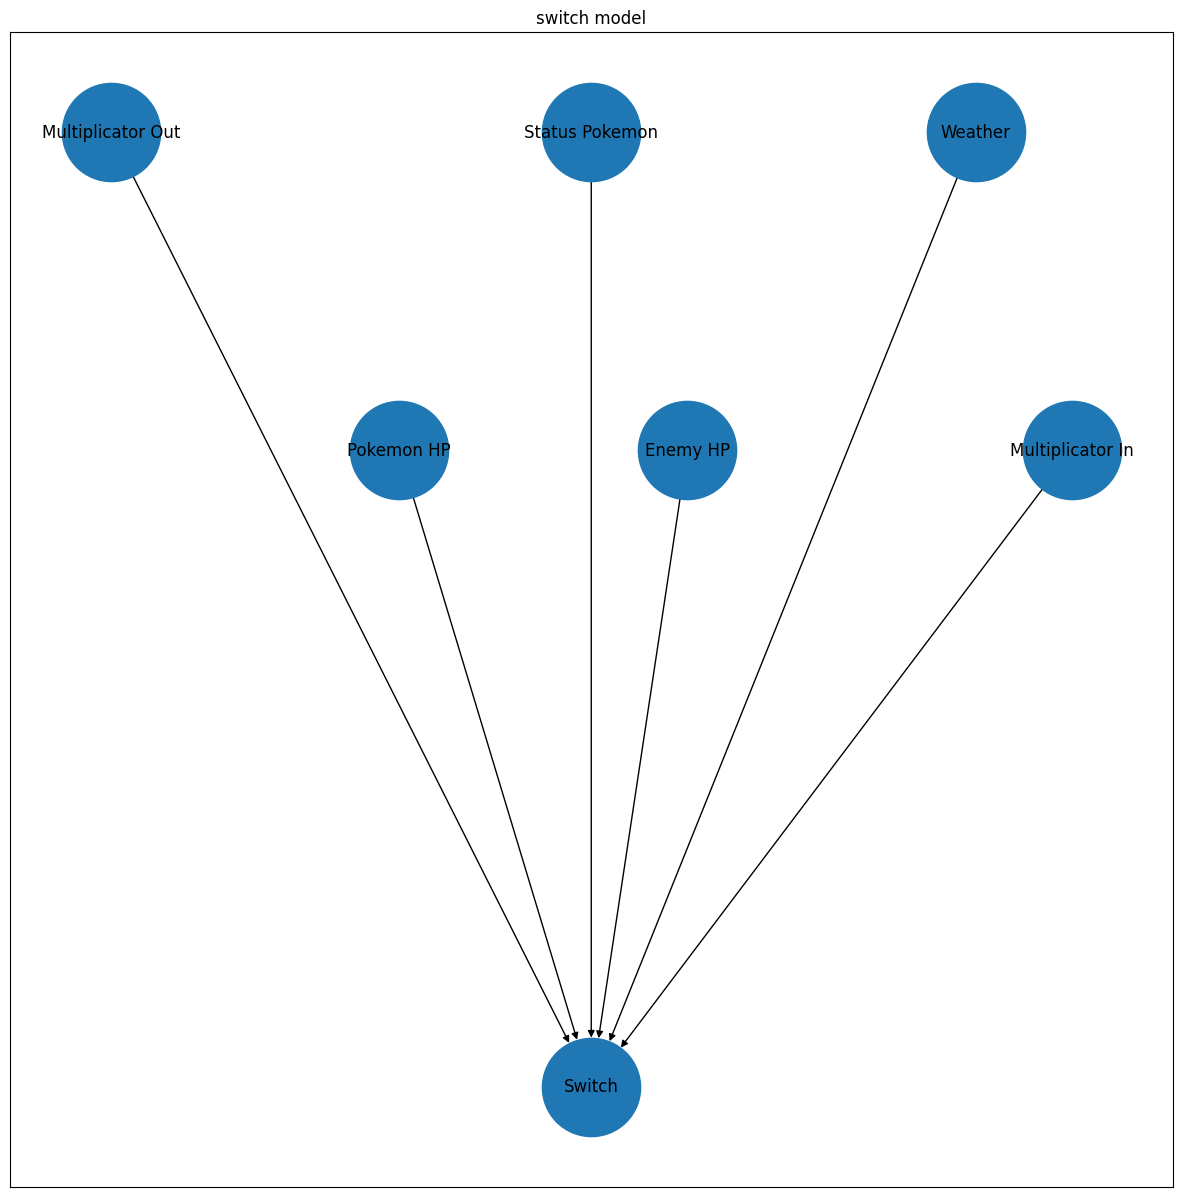

In [13]:
#as we did for the move we create the bayesian network
switch_model = BayesianNetwork([('Pokemon HP', 'Switch'), ('Enemy HP', 'Switch'), ('Status Pokemon', 'Switch'), ('Weather', 'Switch'), ('Multiplicator In', 'Switch'), ('Multiplicator Out', 'Switch')])

position = {'Pokemon HP': [0.9, 0], 'Enemy HP': [1.05, 0],
       "Multiplicator Out": [0.75, 0.15], 'Multiplicator In': [1.25, 0],
       'Switch': [1, -0.3], 'Status Pokemon' : [ 1,0.15], 'Weather' : [1.2, 0.15]}

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
nx.draw_networkx(switch_model, pos=position, ax=ax, node_size=5000)
ax.set_title('switch model')
fig.savefig('switch_bn')

In [14]:
#we estimate the parameter using the Bayesian Estimator
estimator = BayesianEstimator(model=switch_model, data=df_switch)

CPDs = []
#for every node we estimate the parameter and add them to the list
for node in switch_model.nodes():
    CPDs.append(estimator.estimate_cpd(node=node, 
                                       prior_type="BDeu", 
                                       equivalent_sample_size=3500))
switch_model.add_cpds(*CPDs)

print('Checking the model...')
print(f'The model is {switch_model.check_model()}\n\n')

for cpd in [cpd for cpd in switch_model.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd)

Checking the model...
The model is True


CPD for Pokemon HP:
+---------------+-----------+
| Pokemon HP(0) | 0.0912605 |
+---------------+-----------+
| Pokemon HP(1) | 0.100387  |
+---------------+-----------+
| Pokemon HP(2) | 0.11574   |
+---------------+-----------+
| Pokemon HP(3) | 0.139897  |
+---------------+-----------+
| Pokemon HP(4) | 0.552716  |
+---------------+-----------+
CPD for Switch:
+-------------------+-----+------------------------+
| Enemy HP          | ... | Enemy HP(4)            |
+-------------------+-----+------------------------+
| Multiplicator In  | ... | Multiplicator In(16.0) |
+-------------------+-----+------------------------+
| Multiplicator Out | ... | Multiplicator Out(8.0) |
+-------------------+-----+------------------------+
| Pokemon HP        | ... | Pokemon HP(4)          |
+-------------------+-----+------------------------+
| Status Pokemon    | ... | Status Pokemon(tox)    |
+-------------------+-----+------------------------+
| Weather

In [15]:
#we do a little test of the network, with an example of a situation in a battle

#this evidence is of a single move during a turn of a battle


EVIDENCE = {'Multiplicator In': 4, #the entering Pokèmon would have an advantage of 4
            'Multiplicator Out': 1, #the outgoing Pokèmon doesn't have any advantage
            'Enemy HP': 1, #the enemy has low health
            "Pokemon HP": 4, #the outgoing Pokèmon has full health
            "Status Pokemon": "normal", #the outgoing Pokèmon has no alteration
            "Weather": "none",} #The weather is normal

inference = VariableElimination(switch_model)

prob = inference.query(["Switch"],EVIDENCE,show_progress=False)
               
print(prob)


+-------------+---------------+
| Switch      |   phi(Switch) |
+=============+===============+
| Switch(0.0) |        0.0154 |
+-------------+---------------+
| Switch(1.0) |        0.9846 |
+-------------+---------------+


## Trying something different
After doing some test, the perfomance of the network resulted to be low, with a rate of winnin under 50%. One of the hypothesis for why this was happening was because of the dimension of the Network along with its structure. The final variable depends on all the other variable, while them are all independent, this result in a enormous conditional probability at the end, with a lot of possible combination being very rarely but still counted, to reduced this problem i decided to test the same Network but with less variable and possible value, remaining only the most relevant, to see if this could improve the performance.

In [16]:
#after some test we decide to reduce the dimension of the network to see if it could improve its predicting accuracy

enc = KBinsDiscretizer(n_bins=3, encode='ordinal',strategy='kmeans')
enc.fit(df[["Pokemon HP"]])
df["Pokemon HP"] = enc.transform(df[["Pokemon HP"]]).astype(int)

enc.fit(df[["Enemy HP"]])
df["Enemy HP"] = enc.transform(df[["Enemy HP"]]).astype(int)

enc = KBinsDiscretizer(n_bins=3, encode='ordinal',strategy='kmeans')
enc.fit(df[["Boost"]])
df["Boost"] = enc.transform(df[["Boost"]]).astype(int)

df

,User,Sufferer,name move,Power,Pokemon HP,Enemy HP,Weather,Category,Status enemy,Choose,Multiplicator,stab,Boost
0,klinklang,klinklang,Substitute,0,2,2,none,status,normal,1.0,1.0,False,1
1,hydreigon,klinklang,U-turn,1,2,2,none,physical,normal,1.0,1.0,False,1
2,klinklang,emboar,Return,2,2,2,none,physical,normal,1.0,1.0,False,1
3,klinklang,emboar,Substitute,0,2,2,none,status,normal,0.0,1.0,False,1
4,emboar,klinklang,Fire Blast,2,2,2,none,special,normal,1.0,1.0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8468,persian,persian,Nasty Plot,0,2,2,none,status,par,1.0,1.0,False,1
8469,entei,persian,Sacred Fire,2,1,2,none,physical,par,1.0,1.0,True,1
8470,persian,entei,Dark Pulse,1,2,2,none,special,psn,1.0,1.0,False,1
8471,persian,entei,Nasty Plot,0,2,2,none,status,psn,0.0,1.0,False,1


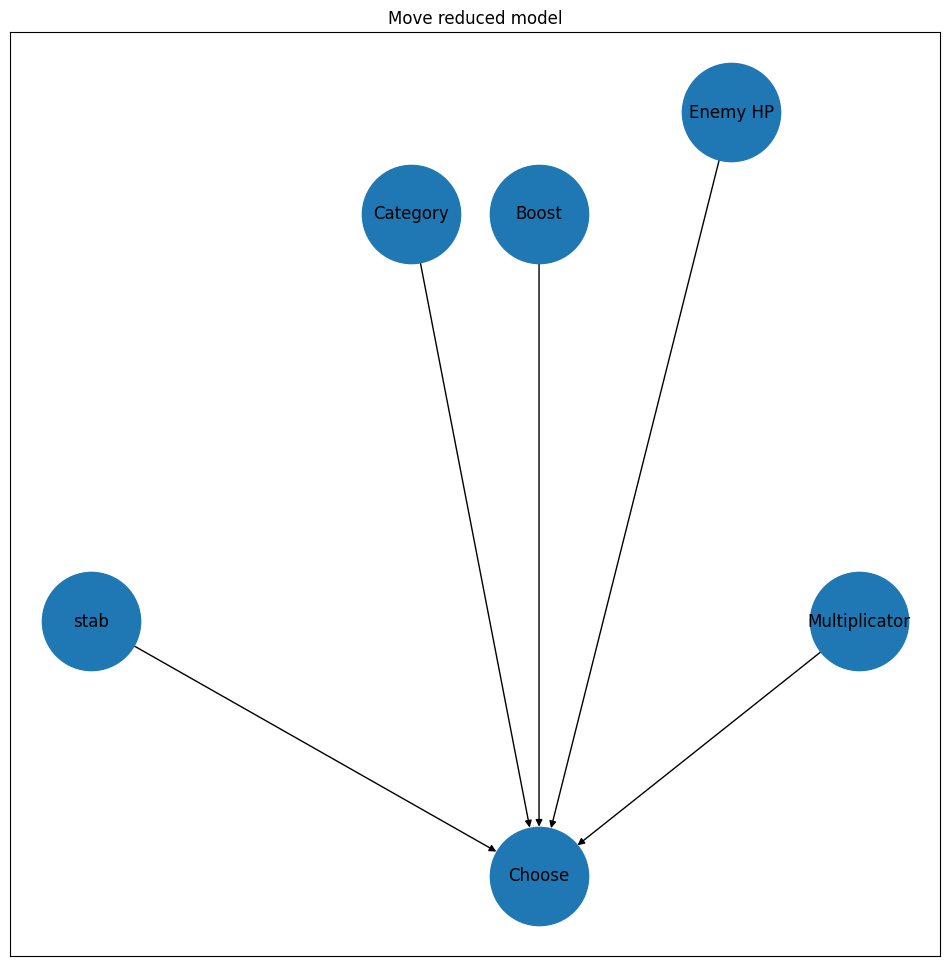

In [17]:
#in this new model we removed the less important node and reduced the number of different value for the remaining
Move_model = BayesianNetwork([('Enemy HP', 'Choose'),('stab', 'Choose'), ('Multiplicator', 'Choose'), 
                                ("Category","Choose"), ("Boost","Choose"),
                                    ])
pos = {'Enemy HP': [1.3, 0],
       "stab": [0.3, -1.], 'Multiplicator': [1.5, -1], 
       'Choose': [1, -1.5],"Category" : [0.8, -0.2], "Boost": [1,-0.2],
       }
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(Move_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Move reduced model')
fig.savefig('MoveREDU_bn')

In [18]:

#we use the Bayesian Estimator to calculate the parameter of the bayesian Network
estimator = BayesianEstimator(model=Move_model, data=df)

CPDs = []
#for every node we estimate the parameter and add them to the list
for node in Move_model.nodes():
    CPDs.append(estimator.estimate_cpd(node=node, 
                                        prior_type="BDeu", 
                                        equivalent_sample_size=3500))
    
#then we add the CPDs to the model
Move_model.add_cpds(*CPDs)

#we check the model
print('Checking the model...')
print(f'The model is {Move_model.check_model()}\n\n')

#and we see the parameter for every node
for cpd in [cpd for cpd in Move_model.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd)

Checking the model...
The model is True


CPD for Enemy HP:
+-------------+----------+
| Enemy HP(0) | 0.132938 |
+-------------+----------+
| Enemy HP(1) | 0.143545 |
+-------------+----------+
| Enemy HP(2) | 0.723517 |
+-------------+----------+
CPD for Choose:
+---------------+-----+--------------------+
| Boost         | ... | Boost(2)           |
+---------------+-----+--------------------+
| Category      | ... | Category(status)   |
+---------------+-----+--------------------+
| Enemy HP      | ... | Enemy HP(2)        |
+---------------+-----+--------------------+
| Multiplicator | ... | Multiplicator(4.0) |
+---------------+-----+--------------------+
| stab          | ... | stab(True)         |
+---------------+-----+--------------------+
| Choose(0.0)   | ... | 0.5                |
+---------------+-----+--------------------+
| Choose(1.0)   | ... | 0.5                |
+---------------+-----+--------------------+
CPD for stab:
+-------------+--------+
| stab(False) | 0.489

In [19]:
#we do a little test of the network, with an example of a situation in a battle

#this evidence is of a single move during a turn of a battle

EVIDENCE = {'Multiplicator': 1, #the move has no advantage nor disadvantage against the enemy
            'stab': True, #the move has the same type of the Pokèmon so the damage is double
            'Enemy HP': 1, #the enemy has low life
            "Category": "physical", #the move does damage
            "Boost":1 #the Pokèmon has a some boost to its statistics
            }

#We choose as inference model the VariableElimination one
inference = VariableElimination(Move_model)

prob = inference.query(["Choose"],EVIDENCE,
                          show_progress=True)
print(prob)

+-------------+---------------+
| Choose      |   phi(Choose) |
+=============+===============+
| Choose(0.0) |        0.3291 |
+-------------+---------------+
| Choose(1.0) |        0.6709 |
+-------------+---------------+


In [20]:

enc = KBinsDiscretizer(n_bins=3, encode='ordinal',strategy='kmeans')
enc.fit(df_switch[["Pokemon HP"]])
df_switch["Pokemon HP"] = enc.transform(df_switch[["Pokemon HP"]]).astype(int)
enc = KBinsDiscretizer(n_bins=3, encode='ordinal',strategy='kmeans')
enc.fit(df_switch[["Enemy HP"]])
df_switch["Enemy HP"] = enc.transform(df_switch[["Enemy HP"]]).astype(int)
df_switch

,Switch In,Switch out,enemy,Pokemon HP,Enemy HP,Status Pokemon,Weather,Switch,Multiplicator In,Multiplicator Out
0,Emboar,Hydreigon,Klinklang,2,2,normal,none,1.0,1.00,1.00
1,Lugia,Klinklang,Emboar,2,2,normal,none,1.0,4.00,1.00
2,Hydreigon,Emboar,Lugia,2,2,normal,none,1.0,2.00,0.25
3,Emboar,Hydreigon,Lugia,2,2,normal,none,1.0,0.25,2.00
4,Hydreigon,Emboar,Lugia,2,2,normal,none,1.0,2.00,0.25
...,...,...,...,...,...,...,...,...,...,...
5809,Fezandipiti,Gyarados,Chansey,2,2,normal,none,1.0,1.00,1.00
5810,Entei,Chansey,Fezandipiti,2,0,psn,none,1.0,1.00,1.00
5811,Rotom,Chansey,Fezandipiti,2,0,psn,none,0.0,1.00,1.00
5812,Persian,Fezandipiti,Entei,0,2,par,none,1.0,1.00,1.00


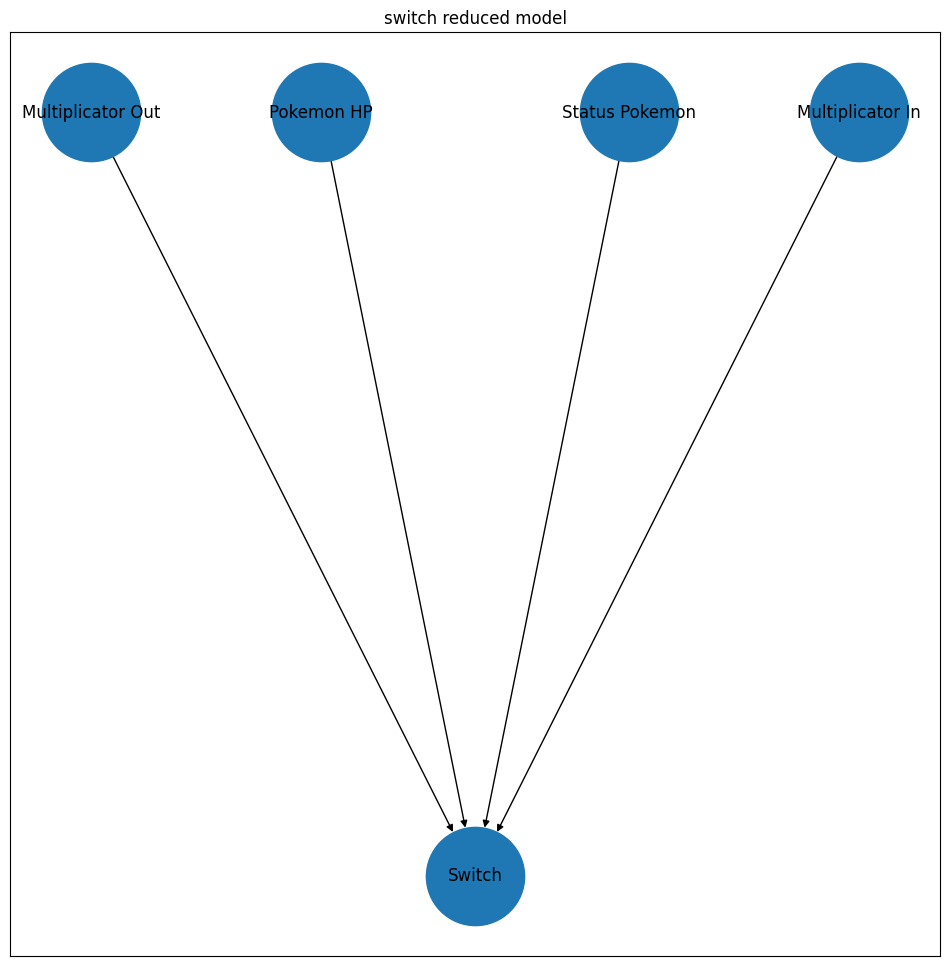

In [21]:
switch_model = BayesianNetwork([('Pokemon HP', 'Switch'), 
                                 ('Status Pokemon', 'Switch'), 
                                 ('Multiplicator In', 'Switch'), ('Multiplicator Out', 'Switch')])
pos = {'Pokemon HP': [0.9, 0],
       "Multiplicator Out": [0.75, 0], 'Multiplicator In': [1.25, 0],
       'Switch': [1, -0.1], 'Status Pokemon' : [1.1, 0]}
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(switch_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('switch reduced model')
fig.savefig('switchREDU_bn')

In [22]:
#we estimate the parameter using the Bayesian Estimator
estimator = BayesianEstimator(model=switch_model, data=df_switch)

CPDs = []
#for every node we estimate the parameter and add them to the list
for node in switch_model.nodes():
    CPDs.append(estimator.estimate_cpd(node=node, 
                                       prior_type="BDeu", 
                                       equivalent_sample_size=3500))
switch_model.add_cpds(*CPDs)

print('Checking the model...')
print(f'The model is {switch_model.check_model()}\n\n')

for cpd in [cpd for cpd in switch_model.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd)

Checking the model...
The model is True


CPD for Pokemon HP:
+---------------+----------+
| Pokemon HP(0) | 0.166595 |
+---------------+----------+
| Pokemon HP(1) | 0.165844 |
+---------------+----------+
| Pokemon HP(2) | 0.667561 |
+---------------+----------+
CPD for Switch:
+-------------------+-----+------------------------+
| Multiplicator In  | ... | Multiplicator In(16.0) |
+-------------------+-----+------------------------+
| Multiplicator Out | ... | Multiplicator Out(8.0) |
+-------------------+-----+------------------------+
| Pokemon HP        | ... | Pokemon HP(2)          |
+-------------------+-----+------------------------+
| Status Pokemon    | ... | Status Pokemon(tox)    |
+-------------------+-----+------------------------+
| Switch(0.0)       | ... | 0.5                    |
+-------------------+-----+------------------------+
| Switch(1.0)       | ... | 0.5                    |
+-------------------+-----+------------------------+
CPD for Status Pokemon:
+-----

In [23]:
#we do a little test of the network, with an example of a situation in a battle

#this evidence is of a single move during a turn of a battle


EVIDENCE = {'Multiplicator In': 4, #the entering Pokèmon would have an advantage of 4
            'Multiplicator Out': 1, #the outgoing Pokèmon doesn't have any advantage
            "Pokemon HP": 2, #the outgoing Pokèmon has full health
            "Status Pokemon": "normal", #the outgoing Pokèmon has no alteration
            } 

inference = VariableElimination(switch_model)

prob = inference.query(["Switch"],EVIDENCE,show_progress=False)
               
print(prob)

+-------------+---------------+
| Switch      |   phi(Switch) |
+=============+===============+
| Switch(0.0) |        0.3818 |
+-------------+---------------+
| Switch(1.0) |        0.6182 |
+-------------+---------------+


## Learning the network structure
As last resort to improve the performance of the network I tried to use a learning algorithm for the structure of the network, so to see if there is some other of dependencies between the variable.
I decided to use the HillClimbSearch with the BDeuScore. For both the switch and move Network I used the full dataset with all the variable.


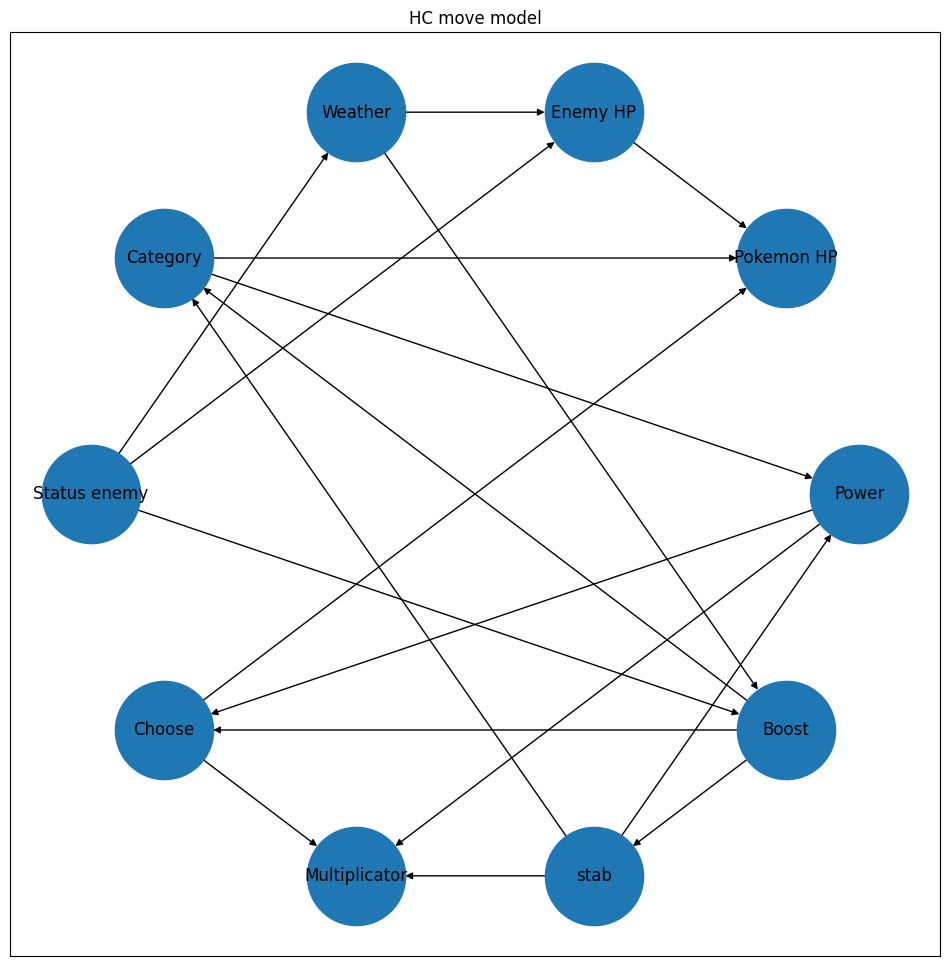

In [43]:
df_learn = df.drop(["User","name move","Sufferer"],axis=1)
scorer = BDeuScore(data=df_learn)
hc = HillClimbSearch(data=df_learn)
hc_move_model = hc.estimate(scoring_method=scorer, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(hc_move_model, pos=nx.drawing.layout.circular_layout(hc_move_model), ax=ax, node_size=5000)
fig.savefig('hc_move')
ax.set_title('HC move model')
hc_move_model = BayesianNetwork(hc_move_model.edges())

In [25]:
#we estimate the parameter using the Bayesian Estimator
estimator = BayesianEstimator(model=hc_move_model, data=df_learn)

CPDs = []
#for every node we estimate the parameter and add them to the list
for node in hc_move_model.nodes():
    CPDs.append(estimator.estimate_cpd(node=node, 
                                       prior_type="BDeu", 
                                       equivalent_sample_size=3500))
hc_move_model.add_cpds(*CPDs)

print('Checking the model...')
print(f'The model is {hc_move_model.check_model()}\n\n')

for cpd in [cpd for cpd in hc_move_model.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd)

Checking the model...
The model is True


CPD for Power:
+----------+---------------------+-----+---------------------+
| Category | Category(physical)  | ... | Category(status)    |
+----------+---------------------+-----+---------------------+
| stab     | stab(False)         | ... | stab(True)          |
+----------+---------------------+-----+---------------------+
| Power(0) | 0.12423749491663277 | ... | 0.7180829641562625  |
+----------+---------------------+-----+---------------------+
| Power(1) | 0.4658397722651484  | ... | 0.07047925896093434 |
+----------+---------------------+-----+---------------------+
| Power(2) | 0.26026840178934524 | ... | 0.07047925896093434 |
+----------+---------------------+-----+---------------------+
| Power(3) | 0.07665717771451809 | ... | 0.07047925896093434 |
+----------+---------------------+-----+---------------------+
| Power(4) | 0.07299715331435543 | ... | 0.07047925896093434 |
+----------+---------------------+-----+---------------------

In [26]:
#we do a little test of the network, with an example of a situation in a battle

#this evidence is of a single move during a turn of a battle

EVIDENCE = {'Multiplicator': 4, #the move has no advantage nor disadvantage against the enemy
            'stab': False, #the move has the same type of the Pokèmon so the damage is double
            'Enemy HP': 1, #the enemy has low life
            "Category": "physical", #the move does damage
            "Boost":1 #the Pokèmon has a some boost to its statistics
            }

#We choose as inference model the VariableElimination one
inference = VariableElimination(hc_move_model)

prob = inference.query(["Choose"],EVIDENCE,
                          show_progress=True)
print(prob)

+-------------+---------------+
| Choose      |   phi(Choose) |
+=============+===============+
| Choose(0.0) |        0.3776 |
+-------------+---------------+
| Choose(1.0) |        0.6224 |
+-------------+---------------+


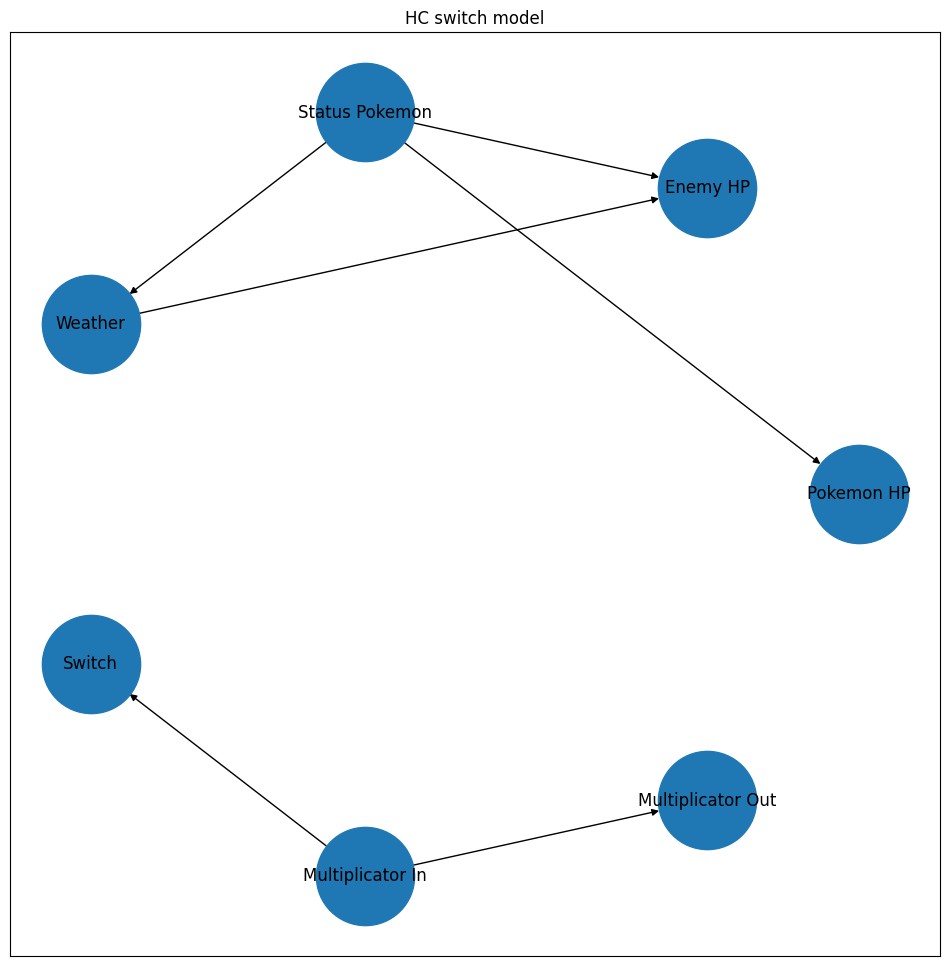

In [27]:
df_learn = df_switch.drop(["Switch In","Switch out","enemy"],axis=1)
scorer = BDeuScore(data=df_learn)
hc = HillClimbSearch(data=df_learn)
hc_switch_model = hc.estimate(scoring_method=scorer, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(hc_switch_model, pos=nx.drawing.layout.circular_layout(hc_switch_model), ax=ax, node_size=5000)
fig.savefig('hc_switch')
ax.set_title('HC switch model')
hc_switch_model = BayesianNetwork(hc_switch_model.edges())

In [28]:
#we estimate the parameter using the Bayesian Estimator
estimator = BayesianEstimator(model=hc_switch_model, data=df_learn)

CPDs = []
#for every node we estimate the parameter and add them to the list
for node in hc_switch_model.nodes():
    CPDs.append(estimator.estimate_cpd(node=node, 
                                       prior_type="BDeu", 
                                       equivalent_sample_size=3500))
hc_switch_model.add_cpds(*CPDs)

print('Checking the model...')
print(f'The model is {hc_switch_model.check_model()}\n\n')

for cpd in [cpd for cpd in hc_switch_model.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd)

Checking the model...
The model is True


CPD for Status Pokemon:
+------------------------+-----------+
| Status Pokemon(brn)    | 0.108761  |
+------------------------+-----------+
| Status Pokemon(frz)    | 0.0603393 |
+------------------------+-----------+
| Status Pokemon(normal) | 0.385334  |
+------------------------+-----------+
| Status Pokemon(par)    | 0.0955551 |
+------------------------+-----------+
| Status Pokemon(psn)    | 0.0835302 |
+------------------------+-----------+
| Status Pokemon(slp)    | 0.0944814 |
+------------------------+-----------+
| Status Pokemon(tox)    | 0.171999  |
+------------------------+-----------+
CPD for Enemy HP:
+----------------+-----+---------------------+
| Status Pokemon | ... | Status Pokemon(tox) |
+----------------+-----+---------------------+
| Weather        | ... | Weather(sunnyday)   |
+----------------+-----+---------------------+
| Enemy HP(0)    | ... | 0.3115264797507788  |
+----------------+-----+---------------------+
| 

In [29]:
#we do a little test of the network, with an example of a situation in a battle

#this evidence is of a single move during a turn of a battle


EVIDENCE = {'Multiplicator In': 4, #the entering Pokèmon would have an advantage of 4
            'Multiplicator Out': 1, #the outgoing Pokèmon doesn't have any advantage
            "Pokemon HP": 2, #the outgoing Pokèmon has full health
            "Status Pokemon": "normal", #the outgoing Pokèmon has no alteration
            } 

inference = VariableElimination(hc_switch_model)

prob = inference.query(["Switch"],EVIDENCE,show_progress=False)
               
print(prob)

+-------------+---------------+
| Switch      |   phi(Switch) |
+=============+===============+
| Switch(0.0) |        0.4524 |
+-------------+---------------+
| Switch(1.0) |        0.5476 |
+-------------+---------------+


## The testing
To test all of this network i used an online battle simulator called [PokemonShowdown](https://play.pokemonshowdown.com) and a project called [showdown](https://github.com/pmariglia/showdown) from Github, which is an interface to let a bot play on the website with the possibility to implement your AI algorithm, as I did with the Bayesian Network. All the network have been tested against 100 random player online and after i collected all the result, as comparison i use the iterative deepeening algorithm.

Because I used an external project, I couldn't show the test here in the notebook. If you want to test the Network, you need to download the repository of this Project from Github and run the file "run.py". In the repository there is a file called "env" that is used for the configuration the line "Battle_bot" is what change the algorithm, to use the full network you need to write "BayesianBot", to use the reduced one you need to write "BayesianBotReduced". After starting the bot to see the battle you need to go on [PokemonShowdown](https://play.pokemonshowdown.com) and log with the credential in the env file on the line "PS_USERNAME" for the username and "PS_PASSWORD" for the password, the default one are "FAIKR3" and "Gengar10?".

If you get the error "TimeOutException", you can try to change the connection, some block the websocket connection.